alpha: 0.07690431050059794 rho: 0.1836117623841108 nu: 1.4098072886417798


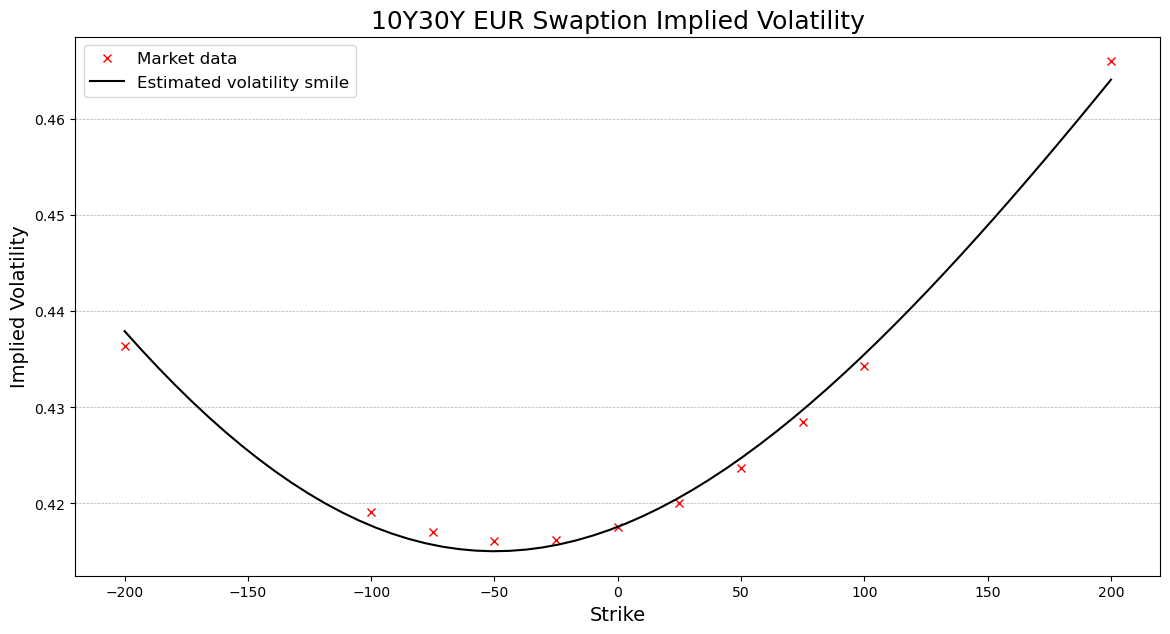

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho):
    '''Given a list of strike prices and SABR parameters, returns what the SABR
    model predicts the market volatility to be. Calculated from equations (2.17) 
    and (2.18) in Hagan, Patrick S., Deep Kumar, Andrew S. Lesniewski, and 
    Diana E. Woodward "Managing smile risk." The Best of Wilmott 1 (2002): 249-296.
    '''
    output = np.zeros(len(K))
    
    for i in range(0,len(K)):
        if K[i] == f: #ATM equation in Managing smile risk
            part_1 = (1.0 - beta)**2.0*alpha**2.0/(24.0*f**(2.0 - 2.0*beta))
            part_2 = rho*beta*alpha*nu/(4.0*f**(1.0 - beta))
            part_3 = (2.0 - 3.0*rho**2)*nu**2.0/24.0
            
            output[i] = (alpha/f**(1 - beta))*(1 + (part_1 + part_2 + part_3)*t_exp )
        
        else:
            logfK = np.log(f/K[i])
            fkbpow = (f*K[i])**((1.0 - beta)/2.0)
            z = nu*fkbpow*logfK/alpha
            xz = np.log((np.sqrt(1.0 - 2.0*rho*z + z**2.0 ) + z - rho)/(1.0-rho))
            
            part_1 = ((1.0-beta)**2.0)*(alpha**2.0)/(24.0*fkbpow**2.0)
            part_2 = (rho*beta*nu*alpha)/(4.0*fkbpow)
            part_3 = (2.0-3.0*rho**2)*nu**2.0/24.0
            part_4 = ((1.0-beta)**2)*(logfK**2)/24.0
            part_5 = ((1.0-beta)**4)*(logfK**4)/1920.0
            
            output[i] = (alpha*z*(1 + (part_1 + part_2 + part_3)*t_exp ))/(fkbpow*xz*(1 + part_4 + part_5 ))
            
    return output

def atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho):
    '''Returns alpha given the forward price, the at-the-money volatility, the 
    time to exirpy (t_exp) and the other parameters in the SABR model by 
    solving a cubic equation for alpha, equation (2.18) in Hagan, Patrick S., 
    Deep Kumar, Andrew S. Lesniewski, and Diana E. Woodward. 
    "Managing smile risk." The Best of Wilmott 1 (2002): 249-296. 
    '''
    #The coeffceints of the polynomial we find the roots of
    p_3 = -sigma_atm
    p_2 =  (1 + (2-3*rho**2)*nu**2*t_exp/24)/f**(1.-beta)
    p_1 = rho*beta*nu*t_exp/(4*f**(2-2*beta))
    p_0 = (1-beta)**2*t_exp/(24*f**(3-3*beta))
    coeffs = [p_0,p_1,p_2,p_3]
    
    r = np.roots(coeffs)    #find the roots of the cubic equation
    
    return r[(r.imag==0) & (r.real>=0)].real.min() 

def SABR_calibration(f, t_exp, sigma_atm, beta, strikes, vols,guess):
    ''' Returns the parameters alpha, nu and rho given a parameter beta, 
    forward price, a list of market volatilities and corrsponding strike 
    spread. Instead of doing a regression in all three parameters, this method 
    calculates alpha when needed from nu and rho. Hence a regression is done 
    in only two variables.
    '''
    def func_to_optimize(K,nu,rho):
        alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
        return  SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho)
     
    popt, pcov = curve_fit(func_to_optimize, strikes, vols, p0 = (guess[1],guess[2]), maxfev=10000)
      
    nu = popt[0]
    rho = popt[1]
    alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
    
    return [alpha, nu, rho]
        


#10Y30Y 2024
beta = 0.5
sigmas = np.array([0.4364, 0.4191, 0.41706,0.41605, 0.41619,0.41757,0.42003,0.42370,0.42847,0.43428,0.46603])
#sigmas = sigmas*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 30
atm_sigma = 0.41757
#atm_sigma =atm_sigma *10
f = 0.23401
#f = f*10
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas, 'x', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
plt.title("10Y30Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y30Y_est.png")  
plt.show()
plt.close()

In [2]:
beta = 0.5
sigmas1 = np.array([0.44983,	0.43478,	0.43329,	0.43288,	0.43360,
                   	0.43559,	0.43846,	0.44256,	0.44772,	0.45385,	0.48650])
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 20
atm_sigma = 0.43559
f = 0.251744
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas1, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

alpha: 0.07980335280568916 rho: 0.20417036723169854 nu: 1.4649390675883547


In [3]:
vols_from_Ks

array([0.45121311, 0.44944798, 0.44775682, 0.44614161, 0.44460433,
       0.4431469 , 0.4417712 , 0.44047904, 0.43927215, 0.43815217,
       0.43712065, 0.43617898, 0.43532845, 0.43457019, 0.43390517,
       0.4333342 , 0.43285788, 0.43247665, 0.43219074, 0.43200018,
       0.43190478, 0.43190417, 0.43199774, 0.4321847 , 0.43246405,
       0.43283461, 0.43329499, 0.43384366, 0.4344789 , 0.43519887,
       0.43600156, 0.43688486, 0.43784657, 0.43888437, 0.43999589,
       0.44117869, 0.44243028, 0.44374815, 0.44512977, 0.4465726 ,
       0.44807411, 0.44963178, 0.45124313, 0.45290571, 0.45461711,
       0.45637496, 0.45817695, 0.46002084, 0.46190444, 0.46382563,
       0.46578235, 0.46777262, 0.46979452, 0.47184621, 0.47392592,
       0.47603194, 0.47816265, 0.48031646, 0.4824919 , 0.48468751])

In [23]:
import numpy as np
from scipy.stats import norm

def sabr_volatility(F, K, T, alpha, beta, rho, nu):
    """
    Calculate the SABR model implied volatility.

    Parameters:
    F : float
        Forward rate of the underlying.
    K : float
        Strike price.
    T : float
        Time to maturity.
    alpha : float
        Volatility of the forward rate at the start.
    beta : float
        Elasticity parameter of the SABR model.
    rho : float
        Correlation between the forward rate and its volatility.
    nu : float
        Volatility of volatility.

    Returns:
    float
        Implied volatility from the SABR model.
    """
    # Avoid division by zero and log of zero
    if F == K:
        FK_beta = (F * K) ** ((1 - beta) / 2)
        z = nu / alpha * FK_beta * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
    else:
        FK_beta = (F * K) ** ((1 - beta) / 2)
        z = nu / alpha * FK_beta * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))

    sigma = (alpha / (FK_beta * (1 + ((1 - beta) ** 2 / 24) * np.log(F / K) ** 2 + 
             ((1 - beta) ** 4 / 1920) * np.log(F / K) ** 4))) * (z / x_z)

    return sigma

def black_formula(F, K, sigma, T, is_call=True):
    """
    Black's formula for pricing European options on futures.

    Parameters:
    F : float
        Forward rate of the underlying.
    K : float
        Strike price.
    sigma : float
        Implied volatility.
    T : float
        Time to maturity.
    is_call : bool
        True if the option is a call, False if it is a put.

    Returns:
    float
        The price of the call/put option using Black's formula.
    """
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if is_call:
        price = np.exp(-T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        price = np.exp(-T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    
    return price

def price_swaption(F, K, T, alpha, beta, rho, nu, is_call=True):
    """
    Price a swaption using the SABR model and Black's formula.

    Parameters:
    F : float
        Forward rate of the swaption.
    K : float
        Strike price.
    T : float
        Time to maturity.
    alpha : float
        Volatility of the forward rate at the start (SABR alpha).
    beta : float
        Elasticity parameter of the SABR model.
    rho : float
        Correlation between the forward rate and its volatility.
    nu : float
        Volatility of volatility.
    is_call : bool
        True if the swaption is a call, False if it is a put.

    Returns:
    float
        The price of the swaption.
    """
    sigma_sabr = sabr_volatility(F, K, T, alpha, beta, rho, nu)
    price = black_formula(F, K, sigma_sabr, T, is_call)
    return price

# Uncomment below lines to test the function
result = price_swaption(0.025, 0.03, 1, 0.04, 0.9, -0.4, 0.25)
print(f"Swaption Price: {result:.6f}")


Swaption Price: 0.000000


In [153]:
#ATM
T=10

# 10Y 1Y
f_1Y = 0.2938
sigma_1Y = 0.53399
p_1Y = black_formula(f_1Y, f_1Y, sigma_1Y, T, is_call=True)
print(p_1Y)

# 10Y 2Y
f_2Y = 0.2976
sigma_2Y = 0.53311
p_2Y = black_formula(f_2Y, f_2Y, sigma_2Y, T, is_call=True)
print(p_2Y)

# 10Y 3Y
f_3Y = 0.2996
sigma_3Y = 0.52101
p_3Y = black_formula(f_3Y, f_3Y, sigma_3Y, T, is_call=True)
print(p_3Y)

# 10Y 5Y
f_5Y = 0.2992
sigma_5Y = 0.50614 
p_5Y = black_formula(f_5Y, f_5Y, sigma_5Y, T, is_call=True)
print(p_5Y)

# 10Y 7Y
f_7Y = 0.2943 
sigma_7Y = 0.49531 
p_7Y = black_formula(f_7Y, f_7Y, sigma_7Y, T, is_call=True)
print(p_7Y)

# 10Y 10Y
f_10Y = 0.2840
sigma_10Y = 0.48315
p_10Y = black_formula(f_10Y, f_10Y, sigma_10Y, T, is_call=True)
print(p_10Y)

# 10Y 12Y
f_12Y = 0.2763
sigma_12Y = 0.46781
p_12Y = black_formula(f_12Y, f_12Y, sigma_12Y, T, is_call=True)
print(p_12Y)

# 10Y 15Y
f_15Y = 0.2654
sigma_15Y = 0.45247
p_15Y = black_formula(f_15Y, f_15Y, sigma_15Y, T, is_call=True)
print(p_15Y)

# 10Y 20Y
f_20Y = 0.2517
sigma_20Y = 0.43559
p_20Y = black_formula(f_20Y, f_20Y, sigma_20Y, T, is_call=True)
print(p_20Y)

# 10Y 30Y
f_30Y = 0.2340
sigma_30Y = 0.41757
p_30Y = black_formula(f_30Y, f_30Y, sigma_30Y, T, is_call=True)
print(p_30Y)


8.023175376913823e-06
8.116438404965462e-06
8.02426553222734e-06
7.830300575636058e-06
7.568628291036159e-06
7.157089462503761e-06
6.780048573489056e-06
6.3336207518555475e-06
5.8164909063470455e-06
5.21509270805393e-06


In [154]:
price =np.array([p_1Y, p_2Y, p_3Y, p_5Y, p_7Y, p_10Y, p_12Y, p_15Y, p_20Y, p_30Y ])
price =price*10000
price

array([0.08023175, 0.08116438, 0.08024266, 0.07830301, 0.07568628,
       0.07157089, 0.06780049, 0.06333621, 0.05816491, 0.05215093])

In [173]:
tenors = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '12Y', '15Y', '20Y', '30Y']
#tenors = [1, 2, 3, 5, 7, 10, 12, 15, 20, 30]
tenors

['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '12Y', '15Y', '20Y', '30Y']

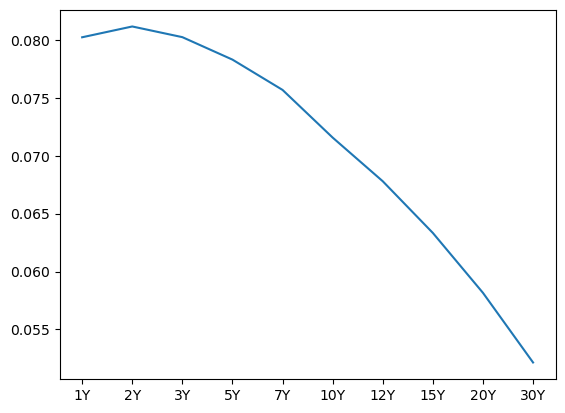

In [174]:
plt.plot(tenors, price)

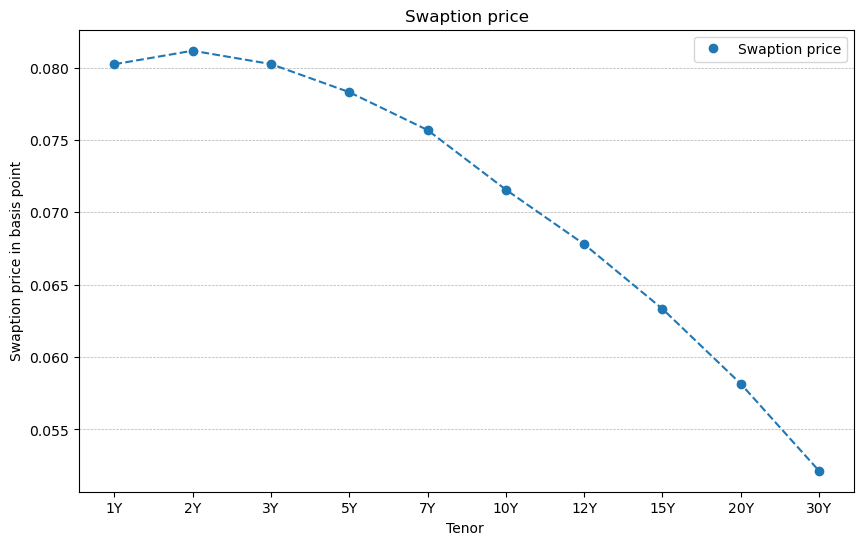

In [183]:
plt.figure(figsize=(10, 6)) 
plt.plot(tenors, price,  linestyle='--', color = 'tab:blue')
plt.plot(tenors, price, 'o', label ='Swaption price')
plt.xlabel('Tenor ')
plt.ylabel('Swaption price in basis point')
plt.title('Swaption price')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/swaption_price_atm.png")
plt.show()
plt.close()